<a href="https://colab.research.google.com/github/EndaleM/clarku-assignment2/blob/master/Endale_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Liberaries
# Credit to Keras, I only made the updates to complete the assignment


In [ ]:
# importing important liberaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
!pip install pyyaml h5py

#Section 1) Fetch of the Kaggle Cats vs Dogs dataset (5%)


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   255M      0  0:00:03  0:00:03 --:--:--  255M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


#Section 2) Coding of the convolutional neural network from scratch following the code example from keras.io (https://keras.io/examples/vision/image_classification_from_scratch/) (30%)

In [ ]:
# Filter out corrupted images
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
# Generate a Dataset
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


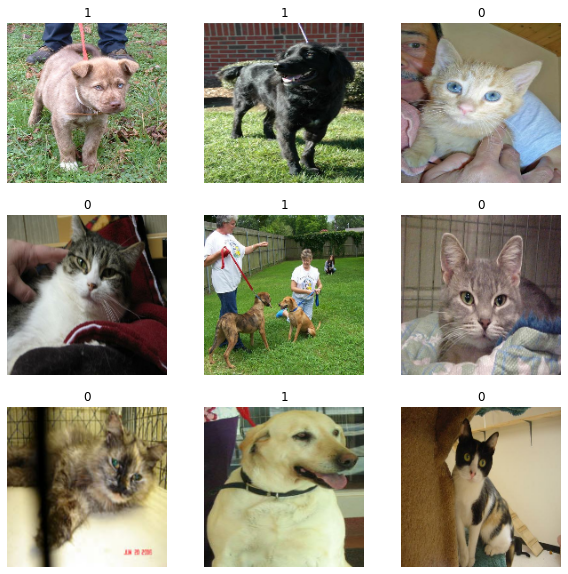

In [ ]:
#Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [ ]:
#Using image data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


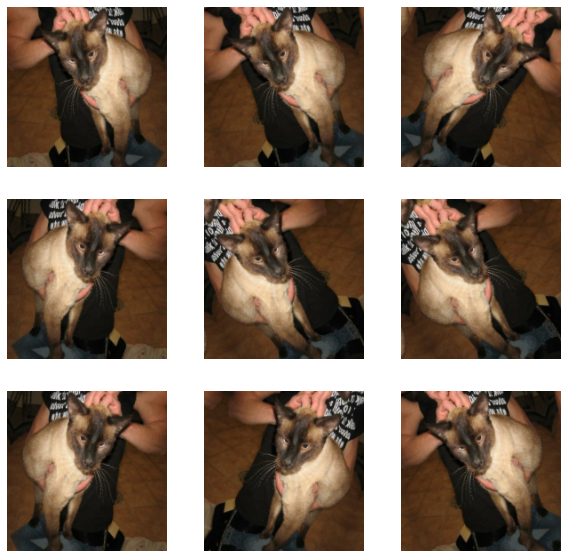

In [ ]:
# visualizing the augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Configuring the dataset for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

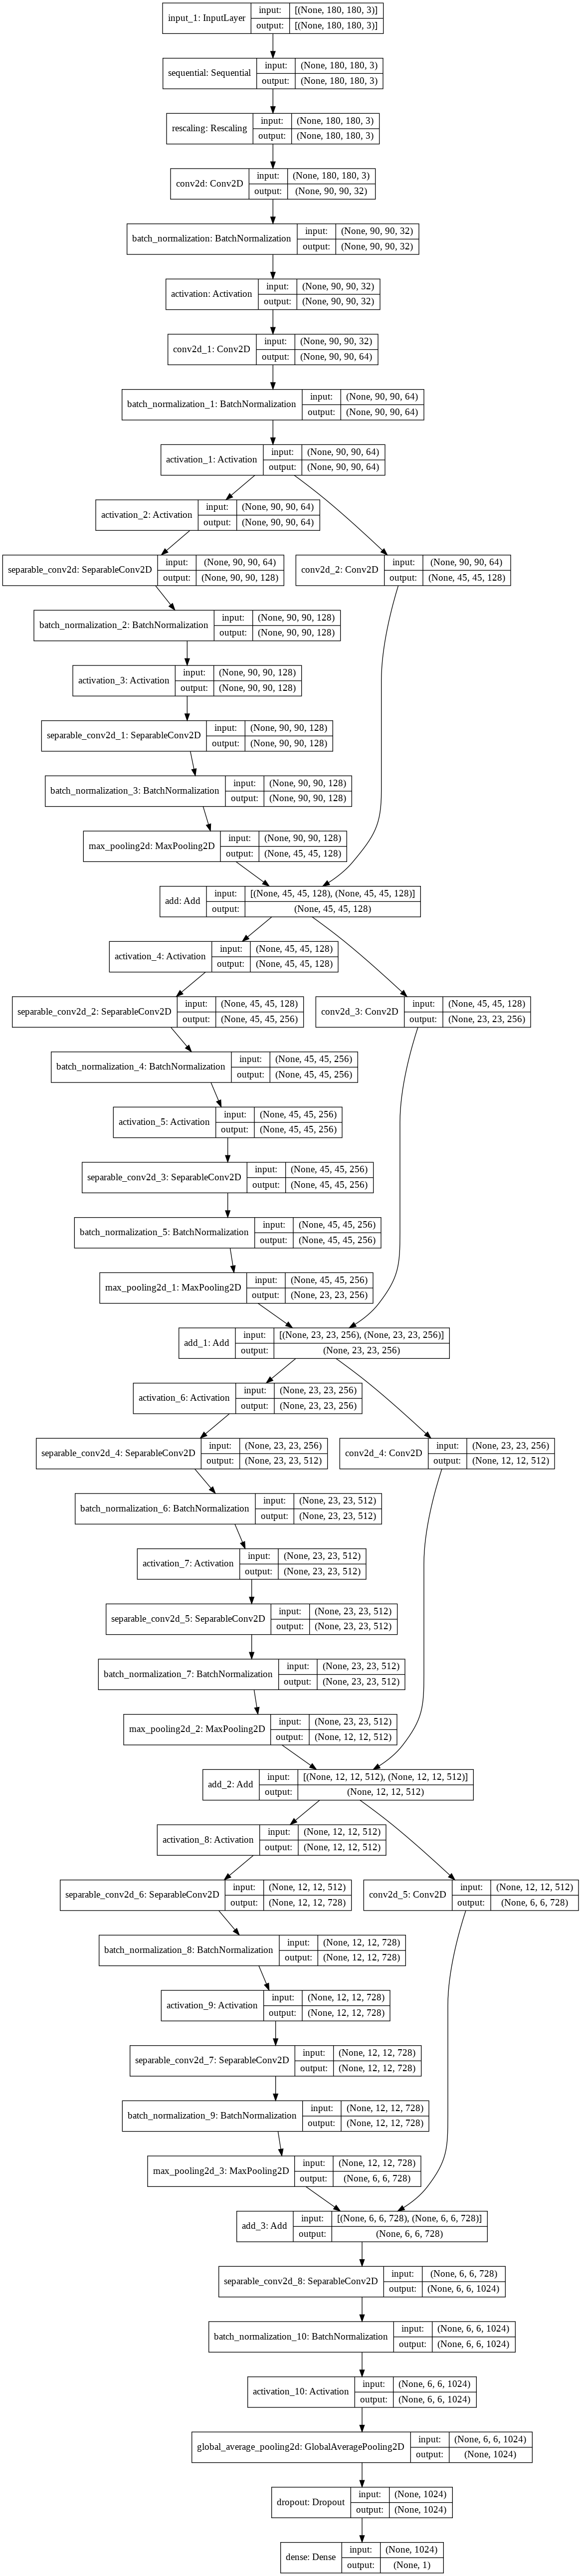

In [ ]:
# Building the model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Section 3) Calculation of the accuracy of the model with 25 epochs and then 50 epochs (15%) also aded with 10 Epochs

In [ ]:
epoch = [10,25,50]
for i in epoch:
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    model.fit(
        train_ds, epochs=i,validation_data=val_ds,
    )
    model.save("my_model{i}.h5")

# Section 4) Code an option that prompts the user for an image online (user to write the full URL of an image) (20%)

In [ ]:
# Importing a liberary
import urllib.request

In [ ]:
# defining a function to save user given jpg file in to Petimages folder
def img_jpg(url, file_path, file_name):
  full_path = file_path + file_name + '.jpg'
  urllib.request.urlretrieve(url, full_path)


In [60]:
#Prompting a user to inut the url for image and also give a file name
url = input('Enter image url to download:')
file_name = input('Enter file name to save as:')


Enter image url to download:https://cache.lovethispic.com/uploaded_images/210306-Cute-Cat.png
Enter file name to save as:cat5


In [61]:
# Calling a fuction and adding the jpg in to petimages file with user provided name
img_jpg(url, 'PetImages/', file_name)

# Section 5) Run your predictor model in the image from the URL submitted by the user and provide the best classification of whether the image is a dog or a cat. (30%)

In [ ]:
#Here you can change the model you like from the attached 10 25 or 50 epoches saved model as h5 format
# Please upload the my_model10.h5 my_model25.h5 my_model50.h5 files attached in my private repo
new_Model = tf.keras.models.load_model('my_model50.h5')


In [62]:
img = keras.preprocessing.image.load_img(
    f"PetImages/{file_name}.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_Model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 48.58 percent cat and 51.42 percent dog.
